In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
### This is intended to be used with UVA Rivanna HPC using a single A100 cluster. ###
CACHE_DIR = f"/scratch/{os.getenv('USER')}/huggingface_cache"

# Collect LM hidden states

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
    cache_dir=CACHE_DIR
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct", cache_dir=CACHE_DIR)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

In [5]:
from transformers.pipelines.text_generation import TextGenerationPipeline, ReturnType
import numpy as np
import torch.nn as nn


class CustomPipeline(TextGenerationPipeline):

    def __init__(self, model, tokenizer, is_cpu=True):
        super().__init__(model=model, tokenizer=tokenizer)
        self.is_cpu = is_cpu
    
    def _forward(self, model_inputs, **generate_kwargs):
        input_ids = model_inputs["input_ids"]
        attention_mask = model_inputs.get("attention_mask", None)
        # Allow empty prompts
        if input_ids.shape[1] == 0:
            input_ids = None
            attention_mask = None
            in_b = 1
        else:
            in_b = input_ids.shape[0]
        prompt_text = model_inputs.pop("prompt_text")

        # If there is a prefix, we may need to adjust the generation length. Do so without permanently modifying
        # generate_kwargs, as some of the parameterization may come from the initialization of the pipeline.
        prefix_length = generate_kwargs.pop("prefix_length", 0)
        if prefix_length > 0:
            has_max_new_tokens = "max_new_tokens" in generate_kwargs or (
                "generation_config" in generate_kwargs
                and generate_kwargs["generation_config"].max_new_tokens is not None
            )
            if not has_max_new_tokens:
                generate_kwargs["max_length"] = generate_kwargs.get("max_length") or self.model.config.max_length
                generate_kwargs["max_length"] += prefix_length
            has_min_new_tokens = "min_new_tokens" in generate_kwargs or (
                "generation_config" in generate_kwargs
                and generate_kwargs["generation_config"].min_new_tokens is not None
            )
            if not has_min_new_tokens and "min_length" in generate_kwargs:
                generate_kwargs["min_length"] += prefix_length

        # BS x SL
        outputs = self.model.generate(input_ids=input_ids, attention_mask=attention_mask, return_dict_in_generate=True, **generate_kwargs)

        # Get scores
        scores = outputs.scores[0][0,:]
        probs = nn.functional.softmax(scores)
        top_probs, top_indices = torch.topk(probs, 10)
        decoded_tokens = [tokenizer.decode([idx]) for idx in top_indices]
        top_k_decoded_tokens = {}
        for token, prob in zip(decoded_tokens, top_probs):
            # print(f"{token}: {prob.item():.4f}")
            top_k_decoded_tokens[token] = prob.item()


        # Get hidden states
        n_layers = len(outputs.hidden_states[0][1:])
        n_tokens = len(outputs.hidden_states[0][0][0, :, 0])
        data = np.full((n_tokens, n_layers), None, dtype=object)                

        for i, layer_hidden_state in enumerate(outputs.hidden_states[0]):
            if i == 0:  # skip the embedding layer
                continue
            for j in range(n_tokens):
                if self.is_cpu:
                    data[j, i-1] = layer_hidden_state[0, j, :].to(torch.float16).detach().cpu().numpy()
                else:
                    data[j, i-1] = layer_hidden_state[0, j, :]
                

        generated_sequence = outputs.sequences
        
        out_b = generated_sequence.shape[0]
        if self.framework == "pt":
            generated_sequence = generated_sequence.reshape(in_b, out_b // in_b, *generated_sequence.shape[1:])
        elif self.framework == "tf":
            generated_sequence = tf.reshape(generated_sequence, (in_b, out_b // in_b, *generated_sequence.shape[1:]))
        return {"generated_sequence": generated_sequence, "input_ids": input_ids, "prompt_text": prompt_text, "hidden_states": data, "top_k_decoded_tokens": top_k_decoded_tokens}

    def postprocess(self, model_outputs, return_type=ReturnType.FULL_TEXT, clean_up_tokenization_spaces=True):
        
        # compute the raw decoded tokens in string format
        generated_sequence = model_outputs['generated_sequence'][0,0,:]
        tokens = [tokenizer.decode([token_id], skip_special_tokens=False, clean_up_tokenization_spaces=False) for token_id in generated_sequence]

        result = super().postprocess(model_outputs, return_type, clean_up_tokenization_spaces)
        output = result[0]
        output["tokens"] = tokens
        output["hidden_states"] = model_outputs["hidden_states"]
        output["top_k_decoded_tokens"] = model_outputs["top_k_decoded_tokens"]
        return output

## Display Hidden States Activations

In [6]:
import pandas as pd
 
messages = "The Space Needle is located in downtown"
max_new_tokens = 1

pipe = CustomPipeline(
    model=model,
    tokenizer=tokenizer
)

generation_args = {
    "max_new_tokens": max_new_tokens,
    "return_full_text": False,
    "temperature": 0.0,
    "output_hidden_states": True,
    "output_scores": True,
}

output = pipe(messages, **generation_args)

tokenized_input = output['tokens'][:-max_new_tokens]
generated_text = output['generated_text']
tokenized_output = output['tokens']
hidden_states = output["hidden_states"]
token_probs = output["top_k_decoded_tokens"]

print("Tokenized Input: ", tokenized_input)
print("Tokenized Output: ", tokenized_output)
print("Output Token probs:")
sorted_token_probs = sorted(token_probs.items(), key=lambda item: item[1], reverse=True)
for token, prob in sorted_token_probs:
    print(f"{token}: {prob:.8f}")


df = pd.DataFrame(hidden_states)
df.columns = ['layer {}'.format(i+1) for i in range(df.shape[1])]
df.index = [tokenized_input]
df

/home/jqm9ba/.conda/envs/nlp/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.
/tmp/ipykernel_1538906/3693652725.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(scores)


Tokenized Input:  ['The', 'Space', 'Need', 'le', 'is', 'located', 'in', 'dow', 'nt', 'own']
Tokenized Output:  ['The', 'Space', 'Need', 'le', 'is', 'located', 'in', 'dow', 'nt', 'own', 'Seattle']
Output Token probs:
Seattle: 0.99661618
Port: 0.00132229
.: 0.00026037
**: 0.00022978
Belle: 0.00017895

: 0.00015793
Se: 0.00013937
,: 0.00013937
of: 0.00009579
_: 0.00007460


,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,...,layer 23,layer 24,layer 25,layer 26,layer 27,layer 28,layer 29,layer 30,layer 31,layer 32
The,"[0.02136, 0.03955, -0.006287, -0.1289, 0.02893...","[0.06055, -0.003418, 0.02124, -0.1816, 0.05225...","[0.0327, -0.1953, -0.03125, -0.3633, -0.1504, ...","[0.04907, -0.1768, -0.031, -0.3281, -0.2695, -...","[0.801, -0.3047, -0.05664, 0.1543, -1.055, 0.3...","[0.8555, -0.2598, -0.03467, 0.1758, -1.047, 0....","[0.824, -0.379, -0.0752, 0.3672, -0.8438, 0.61...","[1.406, -0.707, -0.03027, 0.2432, -1.484, 0.12...","[1.4375, -0.7656, 0.0249, 0.249, -1.4375, 0.15...","[1.469, -0.6094, 0.0679, 0.2695, -1.414, 0.174...",...,"[1.008, -1.828, 0.9062, 0.04053, -1.75, 1.125,...","[1.047, -2.078, 1.1875, 0.1357, -1.5625, 1.055...","[1.141, -2.14, 1.32, 0.3809, -1.586, 1.016, 0....","[1.3125, -2.344, 1.625, 0.5664, -1.422, 0.953,...","[1.18, -2.312, 1.844, 0.582, -1.1875, 0.957, 0...","[0.9453, -2.172, 1.602, 0.1797, -1.219, 0.664,...","[1.445, -2.516, 2.5, 0.2832, -1.633, 0.3867, 0...","[1.016, -0.75, 0.711, -1.094, 0.2422, 0.1309, ...","[1.32, -0.879, 1.953, -0.711, -0.7734, 0.1289,...","[-0.3477, 0.3184, -0.1426, -0.0996, 0.3828, -0..."
Space,"[-0.0698, 0.001419, 0.08887, -0.03125, 0.01318...","[-0.124, 0.01782, 0.1631, -0.003174, 0.05957, ...","[-0.1123, 0.1221, 0.1738, 0.05273, 0.04688, 0....","[0.01318, -0.01709, 0.2021, 0.01465, 0.11426, ...","[0.126, 0.0957, 0.2812, -0.1924, 0.1436, -0.11...","[0.1299, 0.1299, 0.5586, -0.1445, 0.1426, -0.1...","[0.2285, -0.04395, 0.629, -0.2812, 0.2754, -0....","[0.3066, 0.09424, 0.8477, 0.02734, 0.03223, -0...","[0.4336, 0.1357, 1.109, -0.1396, 0.1123, -0.21...","[0.2021, 0.3242, 1.0625, -0.1445, 0.293, -0.24...",...,"[0.6055, 2.14, 3.219, -3.219, 1.875, 0.3594, -...","[1.109, 2.234, 3.922, -3.0, 3.469, -0.1699, -4...","[0.7695, 3.594, 3.344, -3.219, 3.797, -0.2734,...","[1.281, 4.375, 4.28, -3.984, 2.562, 1.273, -5....","[2.344, 5.375, 4.47, -4.094, 5.094, 0.293, -5....","[2.39, 6.906, 2.406, -2.797, 3.875, 0.547, -6....","[1.859, 6.688, 3.156, -1.414, 5.594, 0.6484, -...","[1.1875, 8.75, 3.219, -2.953, 6.062, 0.8125, -...","[1.328, 8.94, 3.422, -3.594, 6.062, 0.789, -6....","[0.797, 2.297, 0.871, -0.3906, 1.641, 0.922, -..."
Need,"[-0.02087, 0.02039, 0.07715, -0.04443, -0.0556...","[-0.0381, 0.0327, 0.1582, -0.0801, -0.0791, -0...","[-0.06177, 0.003418, 0.11816, -0.08594, -0.040...","[-0.08496, 0.289, 0.3496, -0.03125, 0.0459, -0...","[0.06104, 0.3613, 0.1953, 0.1807, -0.10156, -0...","[-0.0825, 0.1719, 0.2461, 0.1816, -0.1309, -0....","[0.1719, 0.0586, 0.1865, 0.1963, 0.05176, -0.6...","[0.2461, -0.1289, -0.2207, 0.59, 0.03198, -0.6...","[0.3828, -0.0791, -0.295, 0.338, 0.2422, -0.59...","[0.42, 0.012695, -0.547, 0.7344, 0.3125, -0.91...",...,"[4.344, -2.922, 0.3418, 1.141, 1.859, -0.418, ...","[3.438, -2.844, 1.844, 1.328, 1.391, -1.109, -...","[3.828, -2.188, 2.516, 2.203, 0.1406, -0.3906,...","[3.36, -3.656, 3.156, 2.75, 0.8203, -0.0586, -...","[2.75, -3.953, 4.75, 3.422, 2.703, -0.633, -0....","[1.5, -2.766, 3.031, 4.25, 2.688, -0.8047, 1.6...","[1.094, -2.672, 4.312, 5.5, 4.062, -0.5, -0.14...","[-0.4922, -2.89, 4.875, 6.438, 5.75, -1.859, 1...","[0.209, -1.805, 4.875, 6.906, 7.75, -1.852, 1....","[0.6953, 0.0598, 1.57, 1.5625, 2.36, -0.4727, ..."
le,"[-0.04053, -0.02893, -0.0141, -0.02881, -0.009...","[0.0227, -0.1406, 0.02197, -0.0232, 0.10156, 0...","[0.1416, -0.00293, 0.03027, -0.042, 0.0669, -0...","[0.3398, 0.1797, -0.1426, 0.06445, 0.0947, -0....","[0.336, 0.2441, -0.1855, 0.3867, 0.00903, 0.08...","[0.2139, 0.1094, -0.5156, 0.742, -0.2178, -0.0...","[0.287, 0.1533, -0.4062, 0.5312, -0.01172, 0.3...","[0.3887, 0.2129, -0.2578, 0.543, -0.2236, -0.1...","[0.2217, -0.126, -0.6055, 0.539, -0.5234, -0.4...","[0.8516, -0.1387, -0.2031, 1.0, -0.8125, -0.37...",...,"[2.734, 1.0, -2.125, 1.164, 2.469, -0.6094, -1...","[2.203, 1.508, -2.406, 1.125, 2.734, -1.719, -...","[4.188, 2.188, -3.0, -0.2852, 2.266, -2.766, 

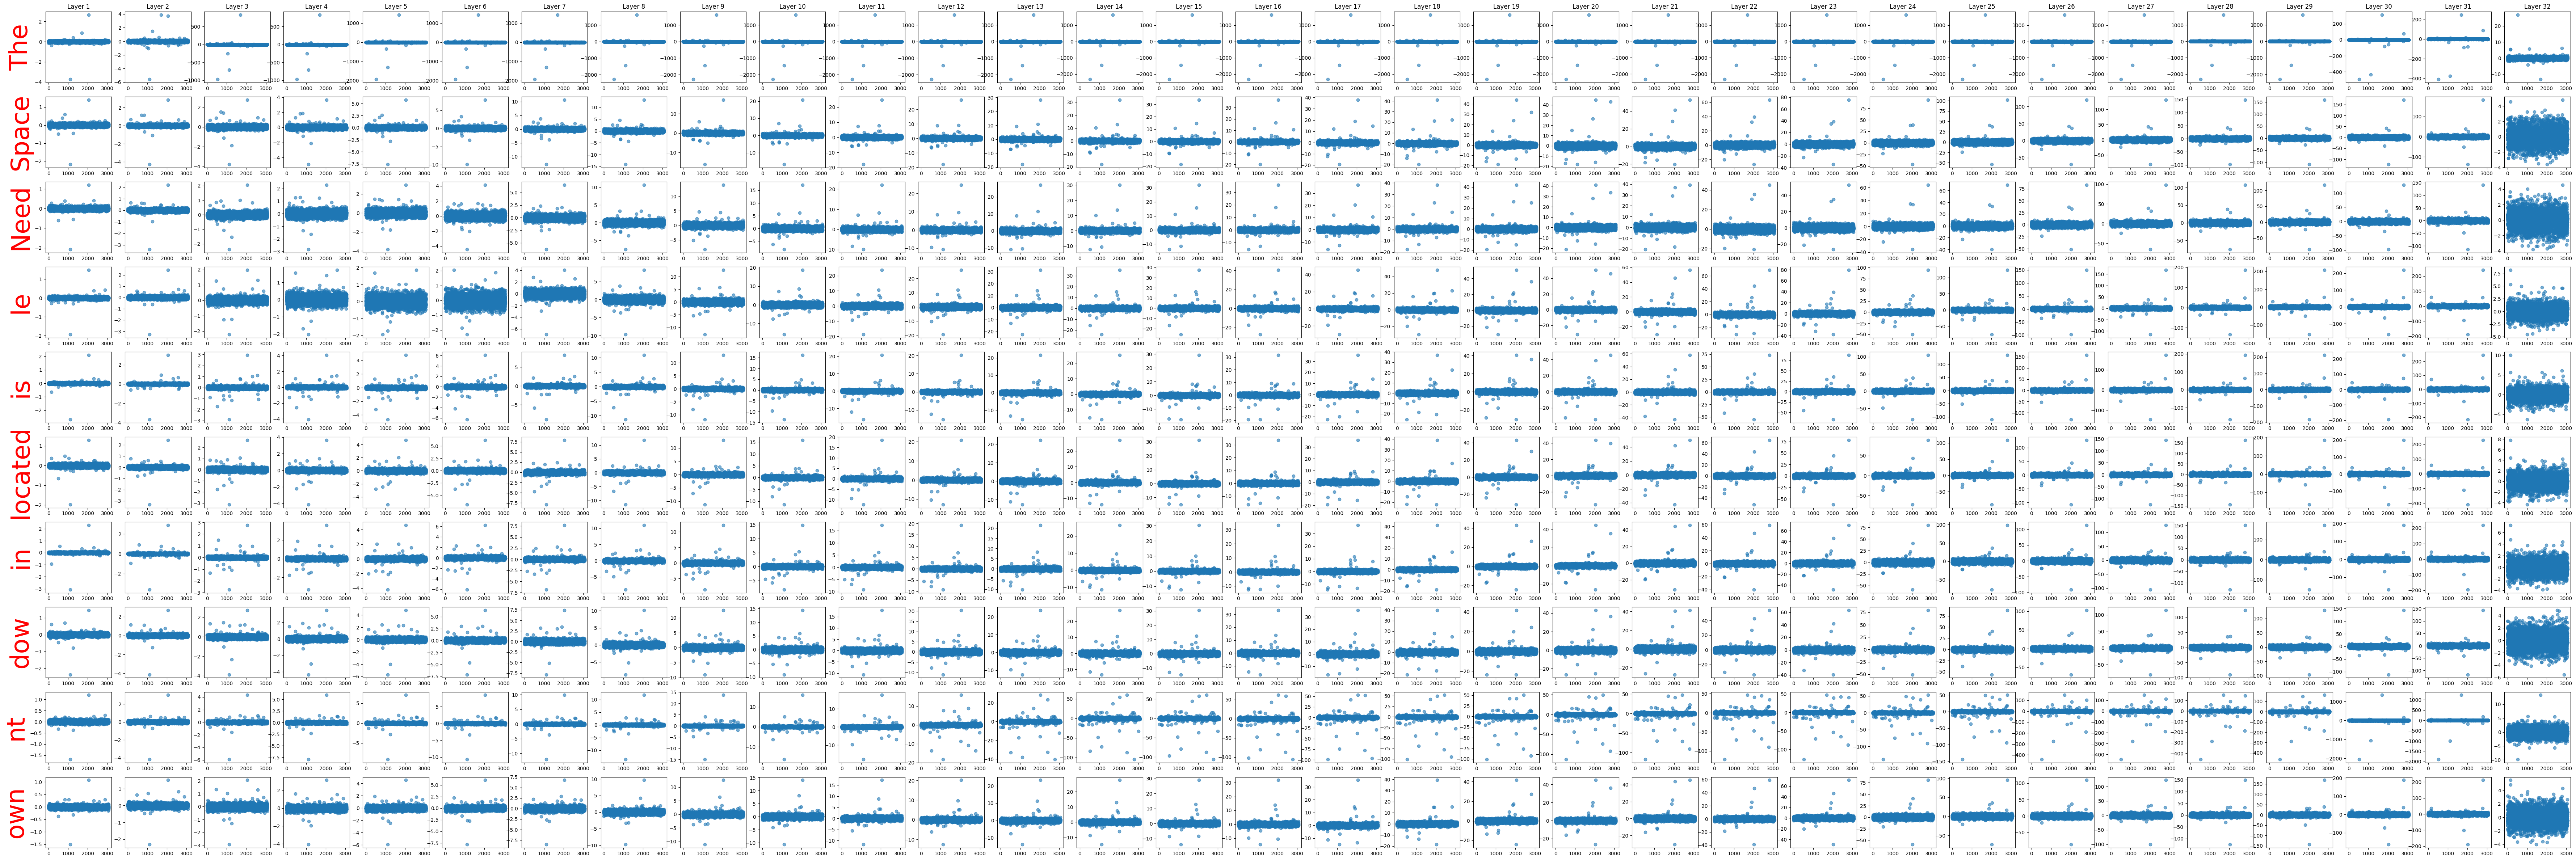

In [7]:
import matplotlib.pyplot as plt

fig_width = 90  
fig_height = 3

# Create a single figure and set the size
fig, axes = plt.subplots(nrows=len(hidden_states), ncols=len(hidden_states[0]), figsize=(fig_width, fig_height*len(hidden_states)))

# Iterate through each row of hidden_states
for i, (row_data, ylabel) in enumerate(zip(hidden_states, tokenized_input)):
    # Set y-label for the entire row
    axes[i, 0].set_ylabel(ylabel, color="red", fontsize=50)

    # Iterate through each entry in the row
    for j, entry in enumerate(row_data):
        # Plot scatter plot in the corresponding subplot
        axes[i, j].scatter(range(len(entry)), entry, alpha=0.6)
        if i == 0:
            axes[i, j].set_title(f"Layer {j+1}")

plt.savefig("mlp_activations.png")
plt.show()

## Train Diffusion layer

In [8]:
gpu_pipe = CustomPipeline(
    model=model,
    tokenizer=tokenizer,
    is_cpu=False
)

gpu_output = gpu_pipe(messages, **generation_args)

# tokenized_input = output['tokens'][:-max_new_tokens]
# generated_text = output['generated_text']
# tokenized_output = output['tokens']
# hidden_states = output["hidden_states"]
# token_probs = output["top_k_decoded_tokens"]

# print("Tokenized Input: ", tokenized_input)
# print("Tokenized Output: ", tokenized_output)
# print("Output Token probs:")
# sorted_token_probs = sorted(token_probs.items(), key=lambda item: item[1], reverse=True)
# for token, prob in sorted_token_probs:
#     print(f"{token}: {prob:.8f}")


# df = pd.DataFrame(hidden_states)
# df.columns = ['layer {}'.format(i+1) for i in range(df.shape[1])]
# df.index = [tokenized_input]
# df

/home/jqm9ba/.conda/envs/nlp/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/tmp/ipykernel_1538906/3693652725.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(scores)


In [9]:
hidden_states = gpu_output["hidden_states"]
hidden_states.shape
hidden_states[0][0].shape

torch.Size([3072])

In [10]:
# import torch
# from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

# model = Unet1D(
#     dim = 64,
#     dim_mults = (1, 2, 4, 8),
#     channels = 32
# )

# diffusion = GaussianDiffusion1D(
#     model,
#     seq_length = 128,
#     timesteps = 2,
#     objective = 'pred_v'
# )

# training_seq = torch.rand(64, 32, 128) # features are normalized from 0 to 1
# dataset = Dataset1D(training_seq)  # this is just an example, but you can formulate your own Dataset and pass it into the `Trainer1D` below

# trainer = Trainer1D(
#     diffusion,
#     dataset = dataset,
#     train_batch_size = 32,
#     train_lr = 8e-5,
#     train_num_steps = 700000,         # total training steps
#     gradient_accumulate_every = 2,    # gradient accumulation steps
#     ema_decay = 0.995,                # exponential moving average decay
#     amp = True,                       # turn on mixed precision
# )
# trainer.train()

# # after a lot of training

# sampled_seq = diffusion.sample(batch_size = 4)
# sampled_seq.shape # (4, 32, 128)


## Apply Trained Diffusion Layer

In [22]:
import copy
modified_model = copy.deepcopy(model)

import re
pattern = r'^model\.layers\.\d+\.mlp$'


# 1. Extract the existing MLP module
for name, module in modified_model.named_modules():
    if re.match(pattern, name):
        MLP = type(module)
        break

# 2. Create ModifiedMLP
class ModifiedMLP(MLP):

    def __init__(self, config, layer):
        super().__init__(config)
        self.layer_num = int(re.findall(r'\d+', layer)[0])

    def forward(self, hidden_states: torch.FloatTensor) -> torch.FloatTensor:
        result = super().forward(hidden_states)
        # do things here
        if self.layer_num >= 5:
            noise = torch.randn_like(result)  
            mu = 0
            sigma = 1
            noise = mu + sigma * noise 
            result += noise 
        return result

# 3. Replace Layers
def replace_layers(parent_model, module_name, old_module, new_module):
    for name, module in parent_model.named_children():
        if module is old_module:
            setattr(parent_model, name, new_module)
        elif hasattr(module, 'named_children') and list(module.named_children()):
            replace_layers(module, module_name, old_module, new_module)

for name, module in modified_model.named_modules():
    if re.match(pattern, name):
        dtype = module.config.torch_dtype
        modified_mlp = ModifiedMLP(module.config, layer=name).to(dtype=dtype).to('cuda:0')
        modified_mlp.load_state_dict(module.state_dict())  # Copy weights
        replace_layers(modified_model, name, module, modified_mlp)

modified_model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): ModifiedMLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=

### Verify Hidden States Activations

In [23]:
pipe = CustomPipeline(
    model=modified_model,
    tokenizer=tokenizer
)

generation_args = {
    "max_new_tokens": 10,
    "return_full_text": False,
    "temperature": 0.0,
    "output_hidden_states": True,
    "output_scores": True,
}

output = pipe(messages, **generation_args)

tokenized_input = output['tokens'][:-max_new_tokens]
generated_text = output['generated_text']
tokenized_output = output['tokens']
hidden_states = output["hidden_states"]
token_probs = output["top_k_decoded_tokens"]

print("Tokenized Input: ", tokenized_input)
print("Tokenized Output: ", tokenized_output)
print("Output Token probs:")
sorted_token_probs = sorted(token_probs.items(), key=lambda item: item[1], reverse=True)
for token, prob in sorted_token_probs:
    print(f"{token}: {prob:.8f}")


# df = pd.DataFrame(hidden_states)
# df.columns = ['layer {}'.format(i+1) for i in range(df.shape[1])]
# df.index = [tokenized_input]
# df

Tokenized Input:  ['The', 'Space', 'Need', 'le', 'is', 'located', 'in', 'dow', 'nt', 'own', 'end', 'head', 'this', 'b', '=', 'all', '/', 'Trans', 'digital']
Tokenized Output:  ['The', 'Space', 'Need', 'le', 'is', 'located', 'in', 'dow', 'nt', 'own', 'end', 'head', 'this', 'b', '=', 'all', '/', 'Trans', 'digital', '(']
Output Token probs:
end: 0.14893356
.: 0.07971839
in: 0.05478960

: 0.04008492
fellow: 0.04008492
dated: 0.03765630
Date: 0.03323157
plan: 0.02754994
,: 0.02588077


/tmp/ipykernel_1538906/3693652725.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(scores)


In [ ]:
import matplotlib.pyplot as plt

fig_width = 90  
fig_height = 3

# Create a single figure and set the size
fig, axes = plt.subplots(nrows=len(hidden_states), ncols=len(hidden_states[0]), figsize=(fig_width, fig_height*len(hidden_states)))

# Iterate through each row of hidden_states
for i, (row_data, ylabel) in enumerate(zip(hidden_states, tokenized_input)):
    # Set y-label for the entire row
    axes[i, 0].set_ylabel(ylabel, color="red", fontsize=50)

    # Iterate through each entry in the row
    for j, entry in enumerate(row_data):
        # Plot scatter plot in the corresponding subplot
        axes[i, j].scatter(range(len(entry)), entry, alpha=0.6)
        if i == 0:
            axes[i, j].set_title(f"Layer {j+1}")

plt.savefig("mlp_activations.png")
plt.show()

### Parameter Estimation using Bayesian Network

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt



# define BN
network = [('A', 'C'), ('B', 'C')]
model = BayesianNetwork(network)
G = nx.DiGraph(network)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, font_size=15, font_color='darkred', arrowstyle='-|>', arrowsize=20)
plt.show()

In [ ]:
# Data for parameter estimation
data = pd.DataFrame(data={'A': [0, 0, 1], 'B': [0, 1, 0], 'C': [1, 1, 0]})
data

##### MLE

In [ ]:
estimator = MaximumLikelihoodEstimator(model, data)
cpd_A = estimator.estimate_cpd('A')
print(cpd_A)
cpd_C = estimator.estimate_cpd('C')
print(cpd_C)

##### Bayesian Estimator

In [ ]:
estimator = BayesianEstimator(model, data)
cpd_C = estimator.estimate_cpd('C', prior_type="dirichlet",
                               pseudo_counts=[[1, 1, 1, 1],
                                              [2, 2, 2, 2]])
print(cpd_C)